In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Surface simulation tutorial

This extends the basic region simulation, covered in the region simulation tutorial, to include the folded cortical surface to the anatomical structure on which the simulation is based, if you haven't already looked at that tutorial you probably should do that now as here we only really discuss in detail the extra things that are specific to a simulation on the cortical surface.

In addition to the components discussed for a region simulation here we introduce one new major component, that is:

1. *Cortex*, the primary component of which is a mesh surface defining a 2d representation of the convoluted cortical surface embedded in 3d space. This object includes a range of ancillary information and methods required for using it in simulations. 

We will also introduce two new *Monitors* that make more sense in the context of surface simulations.

Setup
-----

Here we'll skip quickly over the configuration that was covered in "Tutorial: Anatomy of a Region Simulation". 

In [2]:
#Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import *

   INFO  log level set to INFO


In [3]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])

white_matter_coupling = coupling.Linear(a=0.014)

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2**-4)

WARNING  File 'hemispheres' not found in ZIP.


*Surface*
-----------

Now to the surface itself. The main two attributes of a surface that we'll typically want to modify are
the *LocalConnectivity*, which is a function describing the drop-off in connectivity with distance (in 
its simplest form, think of a truncated Gaussian relative to every vertex of the surface), and the 
*coupling_strength* which is just a weighting of the *LocalConnectivity* function, which potentially can
be specified independently for every vertex (node on the cortical surface).

Here, we'll use the default *LocalConnectivity* function, and scale it appropriately based on the *Model*
*Cortex* and *Connectivity* we'll be using. Unfortunately, for the time being there is not an automated way 
to determine the appropriate coupling strength given the Models selection, etc, so it is necessary to get 
a feeling for a specific system (Models, structure, etc) by experimenting a bit -- we are working toward
tools that will ease this phase of model development.

In [4]:
#Initialise a surface
default_cortex = cortex.Cortex(load_default=True)
default_cortex.coupling_strength = numpy.array([2**-10])

*Monitors*
-----------

The first significant thing of note about surface simulations is that certain *Monitors* make a lot more sense in this
context than they do at the region level, and so we'll introduce a couple new *Monitors* here that we didn't bother with
in the region based example.

The first of these new  *Monitors* is called *SpatialAverage*, this *Monitor* will, unsurprisingly, average over the space
(nodes) of the simulation. In the case of region level simulations we already have a situation of a relatively small number
of nodes, with each one representing a fairly large chunk of brain. In surface simulations on the other hand we can easily
have tens of thousands of nodes, and reducing this by averaging over sensible collections of these nodes can be valuable. 
The basic mechanism is general, in the sense that the nodes can be broken up into any non-overlapping, complete, set of sets
-- said another way, each node can only be counted in one collection and all nodes must be in one collection. As a concrete 
example, even in surface simulations information regarding a break up into regions exists, and this breakup, where each 
cortical mesh node belongs to one and only one region can be used to define the spatial average. In fact this is the default 
behaviour of the *SpatialAverage* monitor when applied to a surface simulation, that is it averages over nodes and returns
region based time-series.

The second of these new *Monitors*, which is an instantiation of a biophysical measurement process, is called *EEG*. This
monitor, hopefully also unsurprisingly, returns the EEG signal resulting from the simulated neural dynamics. EEG signals 
measured on the scalp depend strongly on the location and orientation of the underlying neural sources, which is why this 
monitor is more realistic and useful in the case of surface based simulations -- where the simulation is run on the explicit
geometry of the cortex, which can potentially have been obtained from a specific individual's brain. In addition a simulation
being built on the specific anatomical structure of an individual subject, the specific electrodes used in experimental work
can also be incorporated, providing as direct as possible a link between simulation and experiment.

Here, we'll once again rely on TVB's defaults, where the default *SpatialAverage* monitor will return region level time-series
and the *EEG* monitor will return a relatively standard 62 channel set based on the 10-20 system.

In [5]:
#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=2**-2)
mon_savg = monitors.SpatialAverage(period=2**-2)
# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)
mon_eeg = monitors.EEG(load_default=True, region_mapping=rm)
#Bundle them
what_to_watch = (mon_tavg, mon_savg, mon_eeg)

Simulate
---------

We can then configure and run the *Simulator* as in a region based simulation.

NOTE: in this case the configuration needs to calculate the *LocalConnectivity* for the cortical surface, which can take a minute or two.

In [6]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = oscillator, connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, monitors = what_to_watch,
                          surface = default_cortex)

sim.configure()

Simulator(bound=False, value=None)

In [7]:
#Perform the simulation
tavg_data = []
tavg_time = []
savg_data = []
savg_time = []
eeg_data = []
eeg_time = []
for tavg, savg, eeg in sim(simulation_length=2**2):
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])
    
    if not savg is None:
        savg_time.append(savg[0])
        savg_data.append(savg[1])
    
    if not eeg is None:
        eeg_time.append(eeg[0])
        eeg_data.append(eeg[1])

Pretty Pictures
----------------

And finally, we can look at the results of our simulation in terms of time-series as we have before:

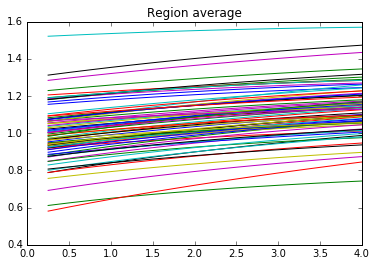

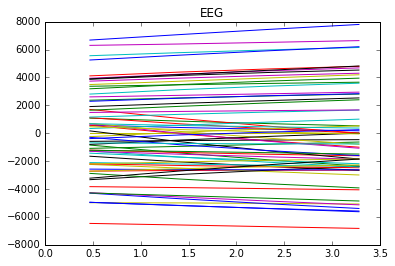

In [8]:
#Make the lists numpy.arrays for easier use.
TAVG = numpy.array(tavg_data)
SAVG = numpy.array(savg_data)
EEG = numpy.array(eeg_data)

#Plot region averaged time series
figure(1)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")

#Plot EEG time series
figure(2)

plot(eeg_time, EEG[:, 0, :, 0])
title("EEG")

#Show them
show()

That's all folks -- so, what's next?
------------------------------------

If you're still interested in surface simulations, then we have a number of other tutorials available,
which you might like to check out, on subjects like: defining a custom *LocalConnectivity*; and 
applying stimuli to a surface simulation. Alternatively, you can get into the details of any aspects 
of TVB simulations that interest you in TVB's hand-book, or the simulator's reference manual (which is
automatically generated from DocStrings within the code)... And, of course, dig into the code itself. 